# Predicting the Weather in Utrecht(NL) with a Recurrent Neural Network focused on a time Series

We will create a predictive model for the weather station based at De Bilt, slightly outside of the city of Utrecht. This location has historically been used as the benchmark for the Netherlands due to its central location

The data ranges from 1970 till today and has been pulled with the help of the KNMY package (https://knmy.readthedocs.io/en/latest/) in a separate notebook. The data is hourly and starts from 1970.

## Data Preparation of Hourly Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [2]:
weather_data = pd.read_csv('DeBilt1970.csv')

In [3]:
weather_data.head(25)

,Date,T,T10N,TD,FH,FF,FX
0,1970-01-01 01:00:00,-104,NaN,-146,51,51,NaN
1,1970-01-01 02:00:00,-102,NaN,-132,36,41,NaN
2,1970-01-01 03:00:00,-97,NaN,-143,36,36,NaN
3,1970-01-01 04:00:00,-100,NaN,-133,31,41,NaN
4,1970-01-01 05:00:00,-103,NaN,-150,31,36,NaN
5,1970-01-01 06:00:00,-112,NaN,-144,31,36,NaN
6,1970-01-01 07:00:00,-117,-120.0,-150,26,21,NaN
7,1970-01-01 08:00:00,-111,NaN,-156,21,31,NaN
8,1970-01-01 09:00:00,-101,NaN,-144,21,26,NaN
9,1970-01-01 10:00:00,-89,NaN,-132,26,26,NaN


We see one peculiarity in this dataset. Namely, one day has 23 datapoints as the midnight datapoint has not been considered byt the dataset. This is not a big issue and just means we need to keep this in mind.

Out of this notebook we will just use the temperature column. It is defintely worth considering keeping a number of other weather data but out of performance considerations, we will not do that now.

In [5]:
weather_train = weather_data.iloc[0:250000,1:2].values #1:2 doesnt select column 2 but makes it a 2D array!
weather_valid = weather_data.iloc[250000:350000,1:2].values
weather_test = weather_data.iloc[350000: ,1:2].values

In [6]:
weather_total=weather_data.iloc[:,1:2].values

After having separated the data set into the  training and test subsets we proceed to adapt our training set for the upcoming Neural Network. To do this we first rescale by substracting the mean of the temperature and dividing by the standard deviation. 


In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
training_set_scaled = sc.fit_transform(weather_train)
valid_set_scaled = sc.transform(weather_valid)
test_set_scaled = sc.transform(weather_test)

In [8]:
training_set_scaled[159600:159628,0]

array([-0.49833183, -0.51286768, -0.52740354, -0.48379597, -0.45472426,
       -0.39658085, -0.32390157, -0.2512223 , -0.22215059, -0.20761474,
       -0.22215059, -0.26575816, -0.29482986, -0.29482986, -0.28029401,
       -0.29482986, -0.32390157, -0.33843743, -0.33843743, -0.30936572,
       -0.38204499, -0.38204499, -0.38204499, -0.36750914, -0.35297328,
       -0.35297328, -0.36750914, -0.36750914])

Having rescaled the data we proceed to create sets of 230(10 days) datapoints that will be used to predict the temperature one day later. It is important to notice here the choice of predicting one day into the future. If we would take the immediate next hour as the point to be predicted, we would create a persistence model. This implies that our Neural Network would choose to use the temperature of one hour prior as the output. This makes sense as the temperature deviations over one hour timespans are very low.

In [9]:
X_train = []
y_train = []
r = list(range(230, len(training_set_scaled)-23))
np.random.shuffle(r)
for i in r:
    X_train.append(training_set_scaled[i-230:i, 0])
    y_train.append(training_set_scaled[i+23, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


X_valid = []
y_valid = []

for i in range(230, len(valid_set_scaled)-23):
    X_valid.append(valid_set_scaled[i-230:i, 0])
    y_valid.append(valid_set_scaled[i+23, 0])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_test = []
y_test = []

for i in range(230, len(test_set_scaled)-23):
    X_test.append(test_set_scaled[i-230:i, 0])
    y_test.append(test_set_scaled[i+23, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

The standard deviation and the mean:

In [22]:
[np.sqrt(sc.var_), sc.mean_]

[array([68.79540529]), array([98.28294])]

## Constructing the Recurrent  Neural Network and training it

### The LSTM network

We now prepare the Regressor Neural Network which will consist of four Long Short Term Memory (LSTM) layers with dropout renormalization. They amount of units chosen are 50 for the outer layers and 60 for the inner ones. These choices came after a fair amount of trial and error and are the ones that seem to obtain the best validation error. Other choices did yield better training results but created overfitting issues. This also applies for the choice of epochs. Most choices seemed to get the best validation loss around 15-20 epochs.

In [13]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.metrics import mean_absolute_error, RootMeanSquaredError
from keras.optimizers import RMSprop

In [14]:
# Initialising the RNN
regressor = Sequential()

# The input and hidden layers:
regressor.add(LSTM(units = 50, 
 return_sequences = True,  input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 60,
dropout=0.2, return_sequences = True))

regressor.add(LSTM(units = 60, dropout =0.4,return_sequences = True))
regressor.add(LSTM(units = 50,dropout = 0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mae')

Train the Neural Network over 15 epochs in batches of $128$ datapoints for the training set and $256$ for the validation set.

In [15]:
regressor.fit(X_train, y_train, epochs = 15,batch_size= 128, validation_data=(X_valid, y_valid), validation_batch_size = 256)

Epoch 1/15
1952/1952 [==============================] - 125s 64ms/step - loss: 0.3482 - val_loss: 0.3271
Epoch 2/15
1952/1952 [==============================] - 127s 65ms/step - loss: 0.3249 - val_loss: 0.3206
Epoch 3/15
1952/1952 [==============================] - 126s 64ms/step - loss: 0.3235 - val_loss: 0.3253
Epoch 4/15
1952/1952 [==============================] - 124s 64ms/step - loss: 0.3183 - val_loss: 0.3206
Epoch 5/15
1952/1952 [==============================] - 124s 63ms/step - loss: 0.3158 - val_loss: 0.3230
Epoch 6/15
1952/1952 [==============================] - 108s 55ms/step - loss: 0.3146 - val_loss: 0.3172
Epoch 7/15
1952/1952 [==============================] - 98s 50ms/step - loss: 0.3128 - val_loss: 0.3168
Epoch 8/15
1952/1952 [==============================] - 99s 51ms/step - loss: 0.3128 - val_loss: 0.3192
Epoch 9/15
1952/1952 [==============================] - 99s 51ms/step - loss: 0.3111 - val_loss: 0.3155
Epoch 10/15
1952/1952 [==============================] - 9

### The GRU network

As a comparison I also present a GRU network. This type of layer is often used instand of an LSTM layer as it often has better performance on hardware for similar results. This is due to the fact it contains one gate less so it contains less parameters.

In [16]:
# Initialising the RNN
regressor1 = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor1.add(GRU(units = 50, 
 return_sequences = True,  input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer and some Dropout regularisation
regressor1.add(GRU(units = 60,
dropout=0.2, return_sequences = True))

# Adding a third LSTM layer and some Dropout regularisation
regressor1.add(GRU(units = 60, dropout =0.5,return_sequences = True))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor1.add(GRU(units = 50,dropout = 0.2))

# Adding the output layer
regressor1.add(Dense(units = 1))

# Compiling the RNN
regressor1.compile(optimizer = 'adam', loss = 'mae')

In [17]:
regressor1.fit(X_train, y_train, epochs = 15,batch_size= 128, validation_data=(X_valid, y_valid), validation_batch_size = 256)

Epoch 1/15
1952/1952 [==============================] - 112s 58ms/step - loss: 0.3390 - val_loss: 0.3228
Epoch 2/15
1952/1952 [==============================] - 112s 57ms/step - loss: 0.3195 - val_loss: 0.3199
Epoch 3/15
1952/1952 [==============================] - 113s 58ms/step - loss: 0.3152 - val_loss: 0.3234
Epoch 4/15
1952/1952 [==============================] - 112s 57ms/step - loss: 0.3129 - val_loss: 0.3156
Epoch 5/15
1952/1952 [==============================] - 113s 58ms/step - loss: 0.3110 - val_loss: 0.3173
Epoch 6/15
1952/1952 [==============================] - 113s 58ms/step - loss: 0.3096 - val_loss: 0.3144
Epoch 7/15
1952/1952 [==============================] - 114s 58ms/step - loss: 0.3074 - val_loss: 0.3151
Epoch 8/15
1952/1952 [==============================] - 114s 59ms/step - loss: 0.3058 - val_loss: 0.3160
Epoch 9/15
1952/1952 [==============================] - 115s 59ms/step - loss: 0.3032 - val_loss: 0.3182
Epoch 10/15
1952/1952 [==============================] 

We see that for this network the results can be similar to the LSTM choice if we choose less epochs as overfitting becomes an issue faster. The overfitting starts appearing sooner but at that stage the training loss is similar to the LSTM one at 15 epochs. SO in less epochs it seems we can obtain a similar level Neural Network hence validating our comment about its performance we made when we introduced it. 

## Predicting and visualising the temperature behaviour

In [19]:
predicted_weather_temp= regressor.predict(X_test)
predicted_weather_temp = sc.inverse_transform(predicted_weather_temp)
y_t = sc.inverse_transform(y_test).flatten().tolist()

In [20]:
mean_absolute_error(np.array(y_t),np.array(predicted_weather_temp.flatten().tolist() )).numpy()

22.04363654359324

The mean absolute error is approximately 2.2 degrees Celsius which is a relatively decent result

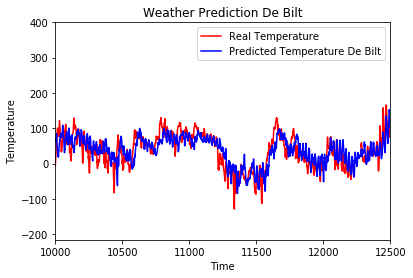

In [24]:
# Visualising the results
plt.plot(y_t, color = 'red', label = 'Real Temperature')
plt.plot(predicted_weather_temp,color = 'blue', label = 'Predicted Temperature De Bilt')
x1,x2,y1,y2 = plt.axis()
plt.axis((10000,12500,y1,y2))
plt.title('Weather Prediction De Bilt')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Comparison with baseline model

We already mentioned the persistence model at an earlier stage. We will now make one which uses the input of 24 hours ago as the output prediction.  This makes sense as, overall, temperatures will not flucutate insanely over that timespan

In [24]:
predictions = list()

for i in range(23,len(weather_test)):
        history = weather_test[i-23][0]
        yhat = history
        predictions.append(yhat)

In [29]:
 from sklearn.metrics import mean_absolute_error

In [28]:
y_t = sc.inverse_transform(y_test).flatten().tolist()
mean_absolute_error(np.array(y_t),np.array(predictions[230:]).flatten().tolist())

23.416792890366338

So we see that we beat the persistence model by approximately 0.15 degrees celsius on the test set. It might be possible to gain a bit more by continue to tinker with our model